# Merged model evaluation

In [3]:
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as ea
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import seaborn as sns
import re
import FusionModel.scripts.ari_group_prior as ag



/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
compMat, labels = ea.get_compMat(criterion='ari', ks=[10, 20, 34, 40, 68], model_types=[
    'all', 'indiv'], sym=['asym'])



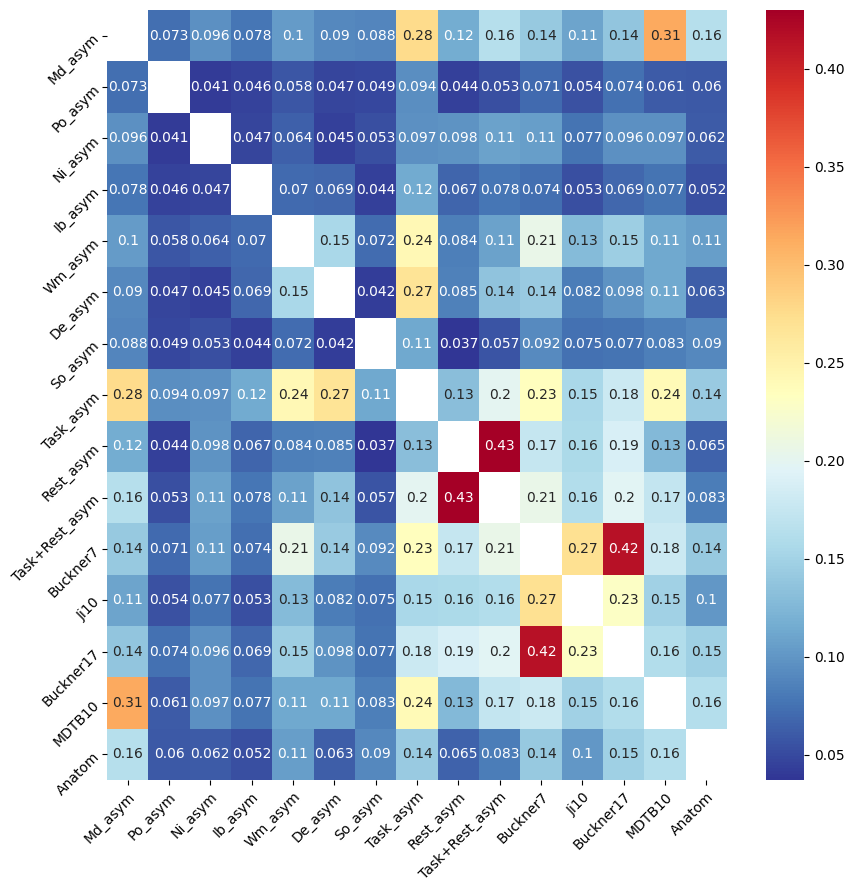

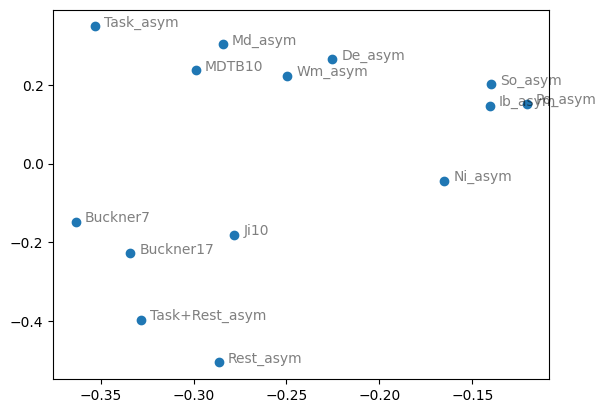

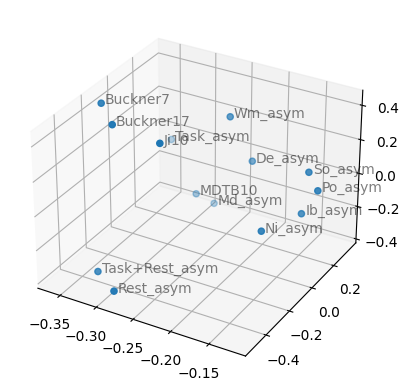

In [5]:
ea.plot_mds(compMat, labels)


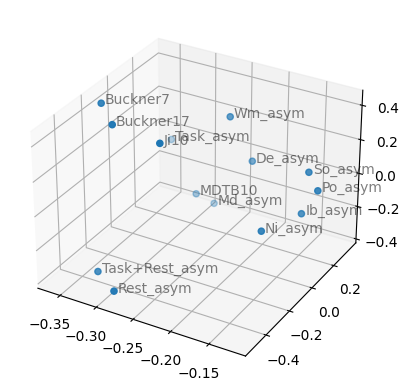

In [6]:
# ---- Plot 3D MDS ----
# Average across Ks
Results_avg = np.mean(compMat, axis=2)

# Remove Anatomical parcellation before calculating MDS
labels_func = labels[:-1]
results_func = Results_avg[:-1, :-1]

# Calculate the eigenvalues and eigenvectors of the correlation coefficient matrix
eigenvalues, eigenvectors = np.linalg.eig(results_func)

# Choose the two eigenvectors with the highest eigenvalues
idx = eigenvalues.argsort()[::-1][:2]
pos = eigenvectors[:, idx]
# Choose the three eigenvectors with the highest eigenvalues
idx = eigenvalues.argsort()[::-1][:3]
pos = eigenvectors[:, idx]
# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
for j in range(pos.shape[0]):
        ax.text(pos[j, 0] + 0.005, pos[j, 1], pos[j, 2], labels[j],
                fontdict=dict(alpha=0.5))

plt.show()


In [7]:
ARI, aris, labels, parcels = ea.compare_across_granularity(
    ks=[10, 20, 34, 40, 68])


In [8]:
granularity_labels = []
dataset_labels = []
for label in labels:
    granularity_labels.append([re.findall(r'\d+', l)[0]
                               for l in label])
    dataset_labels.append([re.findall(r'\D+', l)[0]
                           for idx, l in enumerate(label) if idx == 0][0])


In [9]:

def plot_comp_matrix(aris, labels, parcels):

    # Get numbers at the end of the labels
    granularity_labels = []
    dataset_labels = []
    for label in labels:
        granularity_labels.append([re.findall(r'\d+', l)[0]
                                   for l in label])
        dataset_labels.append([re.findall(r'\D+', l)[0]
                               for idx, l in enumerate(label) if idx == 0][0])

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(11, 9))
    grid = (len(parcels), len(parcels))
    a = 0
    for i, parcel1 in enumerate(parcels):
        for j, parcel2 in enumerate(parcels):

            plt.subplot(grid[0], grid[1], i * grid[0] + j + 1)
            sns.heatmap(aris[a], annot=False, vmin=0, vmax=0.8)
            # sns.heatmap(aris[a], annot=False)
            # plot axis labels
            if i == 0:  # first row
                plt.title(dataset_labels[j])
            if j == 0:  # first column
                plt.ylabel(dataset_labels[i])

            # Remove xticks and yticks for each matrix
            plt.xticks([])
            plt.yticks([])

            a += 1


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_97408/3319772123.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(grid[0], grid[1], i * grid[0] + j + 1)


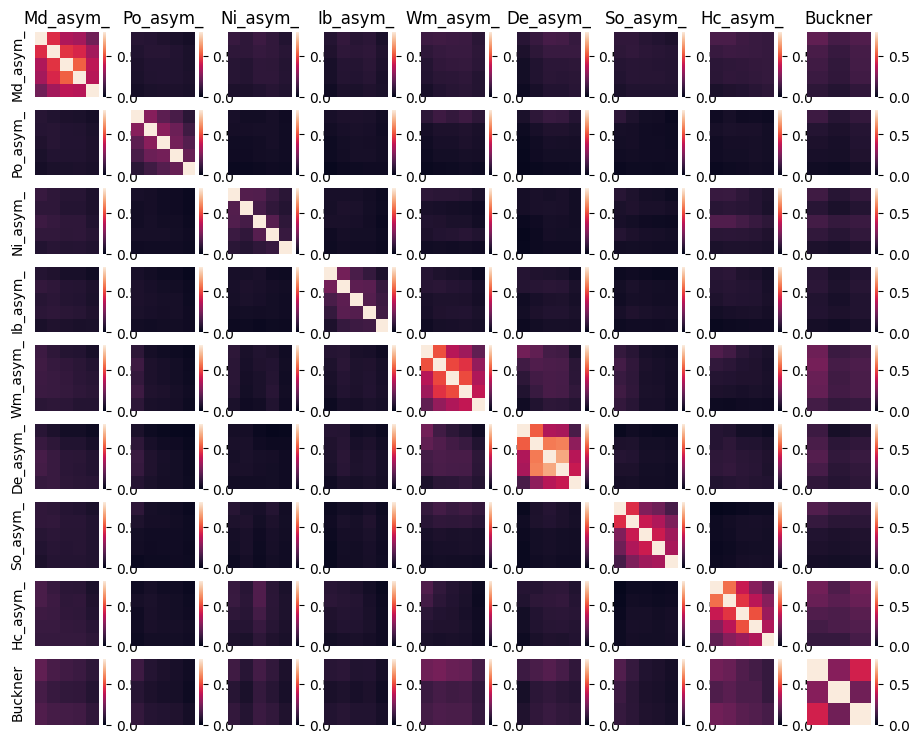

In [10]:
plot_comp_matrix(aris, labels, parcels)


In [11]:
ARI_avg = ea.average_comp_matrix(parcels, aris)


In [12]:
dataset_labels = ['Md', 'Po', 'Ni', 'Ib', 'Wm', 'De', 'So', 'Hc', 'Buckner']

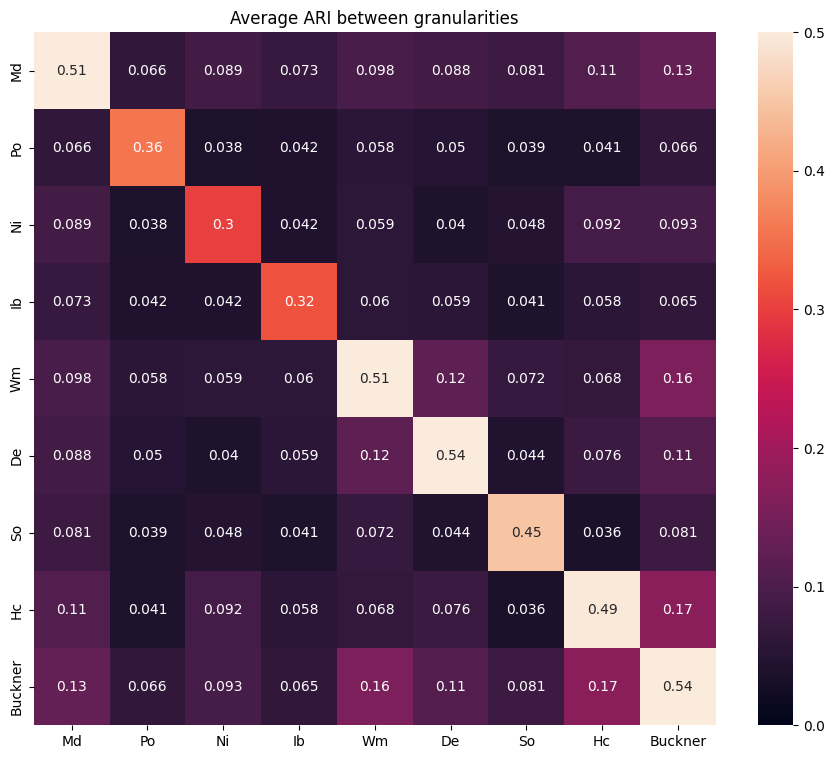

In [13]:
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI, annot=True, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities')
plt.show()
